In [343]:
from datetime import date
from datetime import timedelta
import sys
import os
import json
import sqlite3

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent DataFrame output from wrapping to the next line
pd.options.display.float_format = '{:,.2f}'.format

In [308]:
# Load the datasets
train = pd.read_csv('/app/data/train.csv')
test = pd.read_csv('/app/data/test.csv')
weather = pd.read_csv('/app/data/weather.csv')

# Reduce the length of the items in each column
train_summary = train.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))
test_summary = test.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))
weather_summary = weather.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))

In [309]:
print("Train Data Summary:")
print(train_summary)

Train Data Summary:
             Date           Address           Species  Block            Street  Trap AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent
0      2007-05-29  4100 North Oa...  CULEX PIPIENS...     41   N OAK PARK A...  T002       4100  N OAK P...     41.95     -87.80                9             1           0
1      2007-05-29  4100 North Oa...  CULEX RESTUAN...     41   N OAK PARK A...  T002       4100  N OAK P...     41.95     -87.80                9             1           0
2      2007-05-29  6200 North Ma...  CULEX RESTUAN...     62   N MANDELL AV...  T007       6200  N MANDE...     41.99     -87.77                9             1           0
3      2007-05-29  7900 West Fos...  CULEX PIPIENS...     79      W FOSTER AVE  T015       7900  W FOSTE...     41.97     -87.82                8             1           0
4      2007-05-29  7900 West Fos...  CULEX RESTUAN...     79      W FOSTER AVE  T015       7900  W FOSTE...     41.97   

In [310]:
print("\nTest Data Summary:")
print(test_summary)


Test Data Summary:
            Id        Date           Address           Species  Block            Street   Trap AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy
0            1  2008-06-11  4100 North Oa...  CULEX PIPIENS...     41   N OAK PARK A...   T002       4100  N OAK P...     41.95     -87.80                9
1            2  2008-06-11  4100 North Oa...  CULEX RESTUAN...     41   N OAK PARK A...   T002       4100  N OAK P...     41.95     -87.80                9
2            3  2008-06-11  4100 North Oa...     CULEX PIPIENS     41   N OAK PARK A...   T002       4100  N OAK P...     41.95     -87.80                9
3            4  2008-06-11  4100 North Oa...  CULEX SALINAR...     41   N OAK PARK A...   T002       4100  N OAK P...     41.95     -87.80                9
4            5  2008-06-11  4100 North Oa...  CULEX TERRITA...     41   N OAK PARK A...   T002       4100  N OAK P...     41.95     -87.80                9
...        ...         ...               ...

In [311]:
print("\nWeather Data Summary:")
print(weather_summary)


Weather Data Summary:
      Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool Sunrise Sunset   CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed
0           1  2007-05-01    83    50   67     14        51      56    0    2    0448   1849               0      M      0.0        0.00       29.10    29.82         1.70         27      9.2
1           2  2007-05-01    84    52   68      M        51      57    0    3       -      -               M      M        M        0.00       29.18    29.82         2.70         25      9.6
2           1  2007-05-02    59    42   51     -3        42      47   14    0    0447   1850        BR     0      M      0.0        0.00       29.38    30.09        13.00          4     13.4
3           2  2007-05-02    60    43   52      M        42      47   13    0       -      -     BR HZ     M      M        M        0.00       29.44    30.08        13.30          2     13.4
4           1  2007-05

In [312]:
# Make summary df to view null, stats and data type information along with the first row of the df
def generate_data_summary(df):
    # Create a DataFrame to hold information
    summary = pd.DataFrame()

    # Add dtype of each column
    summary['Dtype'] = df.dtypes

    # Add number of missing values per column
    summary['Missing Values'] = df.isnull().sum()

    # Add number of unique values per column
    summary['Unique Values'] = df.nunique()

    # Descriptive statistics
    stats = df.describe().transpose()  # This generates descriptive statistics
    summary = summary.join(stats[['count', 'mean', 'std', 'min', 'max']], how='outer')  # Join with the summary

    # Add first row to show sample data
    summary['First Row'] = df.iloc[0].apply(str)

    summary = summary.apply(lambda col: col.map(lambda x: (x[:13] + '...') if isinstance(x, str) and len(x) > 13 else x))

    return summary

train_summary = generate_data_summary(train)
test_summary = generate_data_summary(test)
weather_summary = generate_data_summary(weather)

In [313]:
print("Train Data Summary:")
print(train_summary)

Train Data Summary:
                          Dtype  Missing Values  Unique Values     count   mean   std    min    max         First Row
Address                  object               0            138       NaN    NaN   NaN    NaN    NaN  4100 North Oa...
AddressAccuracy           int64               0              4 10,506.00   7.82  1.45   3.00   9.00                 9
AddressNumberAndStreet   object               0            138       NaN    NaN   NaN    NaN    NaN  4100  N OAK P...
Block                     int64               0             64 10,506.00  35.69 24.34  10.00  98.00                41
Date                     object               0             95       NaN    NaN   NaN    NaN    NaN        2007-05-29
Latitude                float64               0            138 10,506.00  41.84  0.11  41.64  42.02          41.95469
Longitude               float64               0            138 10,506.00 -87.70  0.10 -87.93 -87.53        -87.800991
NumMosquitos              int64     

In [314]:
print("\nTest Data Summary:")
print(test_summary)


Test Data Summary:
                          Dtype  Missing Values  Unique Values      count      mean       std    min        max         First Row
Address                  object               0            151        NaN       NaN       NaN    NaN        NaN  4100 North Oa...
AddressAccuracy           int64               0              4 116,293.00      7.95      1.25   3.00       9.00                 9
AddressNumberAndStreet   object               0            151        NaN       NaN       NaN    NaN        NaN  4100  N OAK P...
Block                     int64               0             65 116,293.00     41.13     24.86  10.00      98.00                41
Date                     object               0             95        NaN       NaN       NaN    NaN        NaN        2008-06-11
Id                        int64               0         116293 116,293.00 58,147.00 33,571.04   1.00 116,293.00                 1
Latitude                float64               0            151 116,293

In [315]:
print("\nWeather Data Summary:")
print(weather_summary)


Weather Data Summary:
               Dtype  Missing Values  Unique Values    count  mean   std   min    max   First Row
AvgSpeed      object               0            178      NaN   NaN   NaN   NaN    NaN         9.2
CodeSum       object               0             98      NaN   NaN   NaN   NaN    NaN            
Cool          object               0             31      NaN   NaN   NaN   NaN    NaN           2
Date          object               0           1472      NaN   NaN   NaN   NaN    NaN  2007-05-01
Depart        object               0             42      NaN   NaN   NaN   NaN    NaN          14
Depth         object               0              2      NaN   NaN   NaN   NaN    NaN           0
DewPoint       int64               0             54 2,944.00 53.46 10.68 22.00  75.00          51
Heat          object               0             31      NaN   NaN   NaN   NaN    NaN           0
PrecipTotal   object               0            168      NaN   NaN   NaN   NaN    NaN        0.

In [316]:
# Checking weather columns for non-numeric values
def check_non_numeric(df, column):
    # Temporarily converts values to numbers, marking non-convertibles as NaN
    temp = pd.to_numeric(df[column], errors='coerce')
    if temp.isna().any():
        # Identify rows where conversion failed
        non_numeric_rows = df[temp.isna()]
        return non_numeric_rows[column].unique()

print("Weather data Non-numeric values:")
weather_numeric_cols = ["Station","Tmax","Tmin","Tavg","Depart","DewPoint","WetBulb","Heat","Cool","Sunrise","Sunset","Depth","Water1","SnowFall","PrecipTotal","StnPressure","SeaLevel","ResultSpeed","ResultDir","AvgSpeed"]
for column in weather_numeric_cols:
    non_numeric_value = check_non_numeric(weather, column)
    if non_numeric_value is not None: print(f"{column} {non_numeric_value}")

Weather data Non-numeric values:
Tavg ['M']
Depart ['M']
WetBulb ['M']
Heat ['M']
Cool ['M']
Sunrise ['-']
Sunset ['-']
Depth ['M']
Water1 ['M']
SnowFall ['M' '  T']
PrecipTotal ['  T' 'M']
StnPressure ['M']
SeaLevel ['M']
AvgSpeed ['M']


In [317]:
print("Training data Non-numeric values:")
train_numeric_cols = ["Species","Block","Trap","Latitude","Longitude","AddressAccuracy","NumMosquitos","WnvPresent"]
for column in train_numeric_cols:
    non_numeric_value = check_non_numeric(train, column)
    if non_numeric_value is not None: print(f"{column} {non_numeric_value}")

Training data Non-numeric values:
Species ['CULEX PIPIENS/RESTUANS' 'CULEX RESTUANS' 'CULEX PIPIENS'
 'CULEX SALINARIUS' 'CULEX TERRITANS' 'CULEX TARSALIS' 'CULEX ERRATICUS']
Trap ['T002' 'T007' 'T015' 'T045' 'T046' 'T048' 'T049' 'T050' 'T054' 'T086'
 'T091' 'T094' 'T096' 'T129' 'T143' 'T148' 'T153' 'T159' 'T009' 'T011'
 'T016' 'T019' 'T025' 'T028' 'T031' 'T033' 'T089' 'T090' 'T092' 'T135'
 'T141' 'T142' 'T145' 'T146' 'T147' 'T149' 'T150' 'T151' 'T152' 'T154'
 'T158' 'T162' 'T218' 'T220' 'T001' 'T003' 'T006' 'T008' 'T012' 'T034'
 'T037' 'T040' 'T043' 'T047' 'T051' 'T085' 'T088' 'T161' 'T219' 'T013'
 'T014' 'T018' 'T030' 'T084' 'T144' 'T160' 'T005' 'T017' 'T044' 'T095'
 'T004' 'T035' 'T036' 'T039' 'T060' 'T061' 'T062' 'T065' 'T066' 'T067'
 'T069' 'T070' 'T071' 'T073' 'T074' 'T075' 'T076' 'T077' 'T079' 'T080'
 'T081' 'T082' 'T083' 'T114' 'T155' 'T063' 'T115' 'T138' 'T200' 'T206'
 'T209' 'T212' 'T215' 'T107' 'T128' 'T072' 'T078' 'T097' 'T099' 'T100'
 'T102' 'T103' 'T027' 'T156' 'T157' 'T2

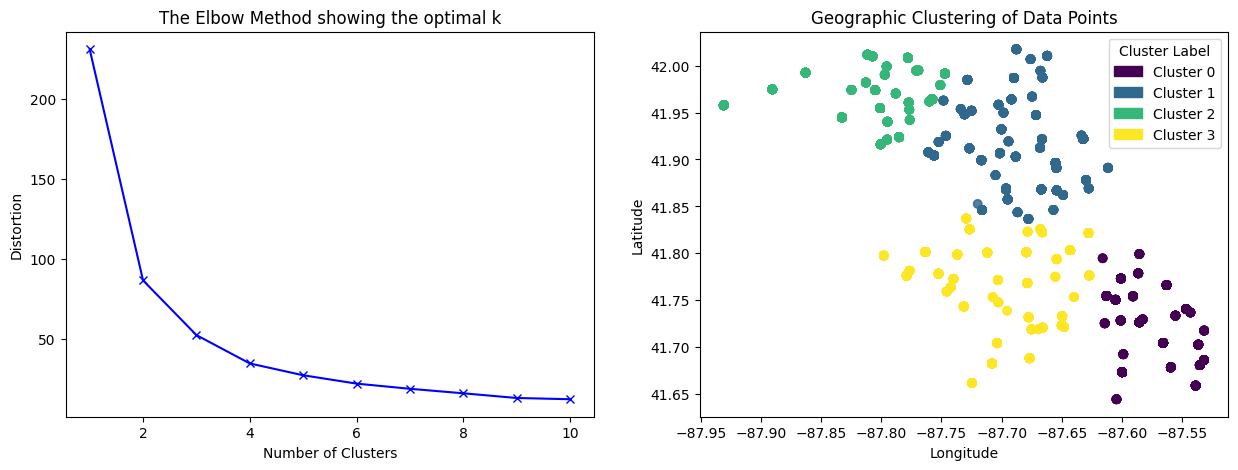


Train Data:
        Date  Species  Block  Trap  Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent  Day_of_Year  Week_of_Year  Month  Day_of_Month  Day_of_Week  Location_Cluster  mosquito_proportion  wnv_case_proportion  wnv_case_proportion_alt
0 2007-05-29        2     41     1     41.95     -87.80                9             1           0          149            22      5            29            1                 2                 0.03                 0.00                     0.10
1 2007-05-29        3     41     1     41.95     -87.80                9             1           0          149            22      5            29            1                 2                 0.03                 0.00                     0.10
2 2007-05-29        3     62     6     41.99     -87.77                9             1           0          149            22      5            29            1                 2                 0.00                 0.00                     0.00
3 2007-

In [318]:
#################################################
## CLEAN TRAIN & TEST DATA
#################################################

# Create copies of the DataFrames
train_clean = train.copy()
test_clean = test.copy()

# Convert 'Date' columns to datetime
train_clean['Date'] = pd.to_datetime(train_clean['Date'])
test_clean['Date'] = pd.to_datetime(test_clean['Date'])

# Train and test have some Trap and Species categories that dont overlap.

common_species = set(train_clean['Species']).intersection(set(test_clean['Species']))
common_traps = set(train_clean['Trap']).intersection(set(test_clean['Trap']))

train_clean = train_clean[train_clean['Species'].isin(common_species) & train_clean['Trap'].isin(common_traps)]
test_clean = test_clean[test_clean['Species'].isin(common_species) & test_clean['Trap'].isin(common_traps)]

# Encoding categorical data in training set and storing mappings
train_clean['Species'] = pd.Categorical(train_clean['Species'])
species_mapping = dict(enumerate(train_clean['Species'].cat.categories))
train_clean['Species'] = train_clean['Species'].cat.codes

test_clean['Species'] = pd.Categorical(test_clean['Species'], categories=species_mapping.values())
test_clean['Species'] = test_clean['Species'].cat.codes

train_clean['Trap'] = pd.Categorical(train_clean['Trap'])
trap_mapping = dict(enumerate(train_clean['Trap'].cat.categories))
train_clean['Trap'] = train_clean['Trap'].cat.codes

test_clean['Trap'] = pd.Categorical(test_clean['Trap'], categories=trap_mapping.values())
test_clean['Trap'] = test_clean['Trap'].cat.codes

# Day of the year is likely important and more granular than month 
train_clean['Day_of_Year'] = train_clean['Date'].dt.dayofyear
train_clean['Week_of_Year'] = train_clean['Date'].dt.isocalendar().week
train_clean['Month'] = train_clean['Date'].dt.month
train_clean['Day_of_Month'] = train_clean['Date'].dt.day
train_clean['Day_of_Week'] = train_clean['Date'].dt.dayofweek

test_clean['Day_of_Year'] = test_clean['Date'].dt.dayofyear
test_clean['Week_of_Year'] = test_clean['Date'].dt.isocalendar().week
test_clean['Month'] = test_clean['Date'].dt.month
test_clean['Day_of_Month'] = test_clean['Date'].dt.day
test_clean['Day_of_Week'] = test_clean['Date'].dt.dayofweek

# Dropping the Address and Street as Trap, Latitude and Longitude are enough
train_clean.drop(['Address', 'Street', 'AddressNumberAndStreet'], axis=1, inplace=True)
test_clean.drop(['Address', 'Street', 'AddressNumberAndStreet', 'Id'], axis=1, inplace=True)

# Cluster the coordinates using K-means clustering. First use the Elbow Method for choosing the right number of clusters (k)
coords_train = train_clean[['Latitude', 'Longitude']]
distortions = []
K = range(1, 11) 
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(coords_train)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
# plt.show()

kmeans = KMeans(n_clusters=4) # 4 was best, found using the Elbow Method above
train_clean['Location_Cluster'] = kmeans.fit_predict(coords_train)

coords_test = test_clean[['Latitude', 'Longitude']]
test_clean['Location_Cluster'] = kmeans.predict(coords_test)

plt.subplot(1,2,2)
scatter = plt.scatter(train_clean['Longitude'], train_clean['Latitude'],
                      c=train_clean['Location_Cluster'], cmap='viridis', alpha=0.6)
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # Get the colormap colors
labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(4)]
plt.legend(handles=patches, title='Cluster Label')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Clustering of Data Points')
plt.show()

# Aggregate data by 'Trap'
trap_stats = train_clean.groupby('Trap').agg(
    total_mosquitos=pd.NamedAgg(column='NumMosquitos', aggfunc='sum'),
    total_wnv_cases=pd.NamedAgg(column='WnvPresent', aggfunc='sum')
)
# Percentage of mosquitoes caught in each trap / total caught mosquitoes, e.g. 10% of all mosquitos were caught in Trap 1
trap_stats['mosquito_proportion'] = trap_stats['total_mosquitos'] / trap_stats['total_mosquitos'].sum()
# Percentage of WNV cases in each trap / total caught mosquitoes in each trap, e.g. 5% of mosquitos in Trap 1 tested positive for WNV
trap_stats['wnv_case_proportion'] = trap_stats['total_wnv_cases'] / trap_stats['total_mosquitos']
# Percentage of times WNV was recorded / number of times each trap was recorded, e.g. Trap 1 had at least one positive WNV case 50% of the times it was checked.
trap_stats['wnv_case_proportion_alt'] = train_clean.groupby('Trap')['WnvPresent'].apply(lambda x: x.sum() / len(x))
# Reset index to make 'Trap' a column again for mapping
trap_stats.reset_index(inplace=True)
# Create mappings for each feature
mosquito_proportion_map = dict(zip(trap_stats['Trap'], trap_stats['mosquito_proportion']))
wnv_case_proportion_map = dict(zip(trap_stats['Trap'], trap_stats['wnv_case_proportion']))
wnv_case_proportion_alt_map = dict(zip(trap_stats['Trap'], trap_stats['wnv_case_proportion_alt']))
# Apply mappings to original DataFrame
train_clean['mosquito_proportion'] = train_clean['Trap'].map(mosquito_proportion_map)
train_clean['wnv_case_proportion'] = train_clean['Trap'].map(wnv_case_proportion_map)
train_clean['wnv_case_proportion_alt'] = train_clean['Trap'].map(wnv_case_proportion_alt_map)
# Apply mappings to the test DataFrame
test_clean['mosquito_proportion'] = test_clean['Trap'].map(mosquito_proportion_map).fillna(0)  # Assuming 0 as default for unseen traps
test_clean['wnv_case_proportion'] = test_clean['Trap'].map(wnv_case_proportion_map).fillna(0)  # Assuming 0 as default for unseen traps
test_clean['wnv_case_proportion_alt'] = test_clean['Trap'].map(wnv_case_proportion_alt_map).fillna(0)  # Assuming 0 as default for unseen traps

print("\nTrain Data:")
print(train_clean.head())

print("\nTest Data:")
print(test_clean.head())

train_summary = generate_data_summary(train_clean)
test_summary = generate_data_summary(test_clean)

print("\nTrain Data Summary:")
print(train_summary)

print("\nTest Data Summary:")
print(test_summary)

Conversion successful.


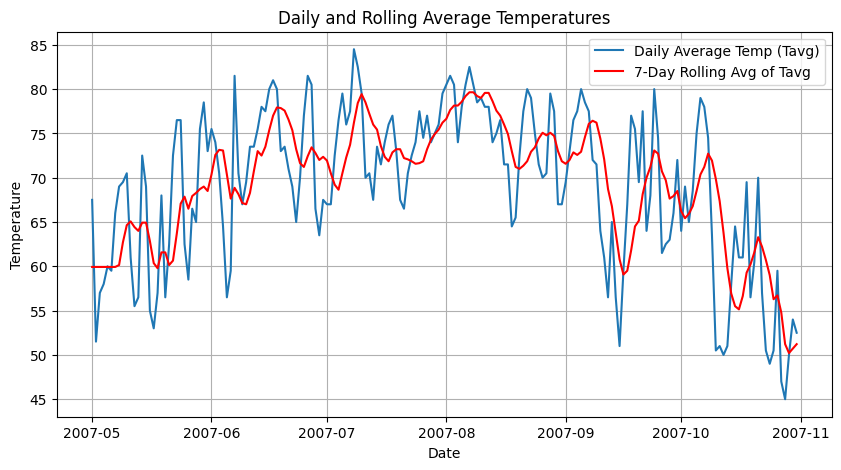


Cleaned Weather Data Summary:
                               Dtype  Missing Values  Unique Values    count                 mean   std                  min                  max         First Row
AvgSpeed                     float64               0            357 1,472.00                 8.58  3.11                 2.00                23.85  9.39999999999...
AvgSpeed_7day_avg            float64               0            855 1,472.00                 8.56  1.63                 4.54                14.71  11.8071428571...
AvgSpeed_lag1                float64               0            356 1,472.00                 8.57  3.09                 2.00                23.85  9.39999999999...
Cool                         float64               0             50 1,472.00                 5.64  6.06                 0.00                28.50               2.5
Date                  datetime64[ns]               0           1472 1,472.00  2011-01-30 06:00:00   NaN  2007-05-01 00:00:00  2014-10-31 00:00:00  20

In [319]:
#################################################
## CLEAN WEATHER DATA
#################################################

weather_clean = weather.copy()
weather_clean['Date'] = pd.to_datetime(weather_clean['Date'])

### DEAL WITH NON-NUMERIC VALUES IN NUMERIC COLUMNS ###
# Make M or - a repeat of the value above. T represents trace amounts of precipitation in "PrecipTotal" so make 0.001
weather_clean.replace({'M': pd.NA, '-': pd.NA, '  T': '0.001'}, inplace=True)

# Fill 'M' and '-' in specific columns with the value from the previous row (same day, other station)
weather_clean[weather_numeric_cols] = weather_clean[weather_numeric_cols].ffill()

try:
    # Convert all numerical columns to float for averaging later, raises an error if conversion fails. Alt. errors='coerce' will convert non-convertible values to NaN
    weather_clean[weather_numeric_cols] = weather_clean[weather_numeric_cols].apply(pd.to_numeric, errors='raise')
    print("Conversion successful.")
except ValueError as e:
    print(f"Weather df conversion failed: {e}")
    print(weather_clean.head())

### REMOVE UNHELPFUL COLUMNS ###
# Remove the 'Water1' column as it is always 'M' and thus useless
weather_clean.drop(columns=['Water1'], inplace=True)

# We'll average the data from the two stations so drop 'Station'
weather_clean.drop(columns=['Station'], inplace=True)

# CodeSum weather condition information is likely captured by other measurable features (temp, precipitation, humidity, and wind)
weather_clean.drop(columns=['CodeSum'], inplace=True)

# Depthis always zero
weather_clean.drop(columns=['Depth'], inplace=True)

# Group by Date and take the mean of the numerical columns to combine the two station rows
weather_grouped = weather_clean.groupby('Date').mean().reset_index()

### ADD FEATURES: ROLLING AVERAGES ###
# Most species have an average development time from egg to larva of about 7 to 10 days.
# A 10-day window was chosen to capture the entire development cycle for the majority of the species.
# May also test 7-day window as 10-day might miss critical thresholds that influence development rates
# Rolling averages were added for 
#   - Tmax, Tmin, Tavg: affects mosquito metabolism, behavior, development cycle.
#   - DewPoint and WetBulb: moisture and humidity affect mosquitoes survival and egg hatching
#   - PrecipTotal: impacts the availability of breeding sites 
#   - ResultSpeed, ResultDir, AvgSpeed: wind speed and direction affect mosquito flight and dispersal patterns
window_days = 7
feature_cols = ["Tmax","Tmin","Tavg","DewPoint","WetBulb","PrecipTotal","StnPressure","ResultSpeed","ResultDir","AvgSpeed"]

# Assuming 'Date' is a datetime column
weather_grouped['Year'] = weather_grouped['Date'].dt.year
weather_grouped['Month'] = weather_grouped['Date'].dt.month

# Create a mask for the season (May to October)
weather_grouped['In_Season'] = weather_grouped['Month'].between(5, 10)

for feat in feature_cols:
    # 1-day lag of 'Tmax'
    weather_grouped[f'{feat}_lag1'] = weather_grouped[feat].shift(1)
    weather_grouped.loc[0, f'{feat}_lag1'] = weather_grouped.loc[0, feat]

    # Calculate rolling average only within the same season
    weather_grouped[f'{feat}_{window_days}day_avg'] = weather_grouped.groupby(['Year', 'In_Season'])[feat].rolling(window=window_days, min_periods=window_days).mean().reset_index(level=[0,1], drop=True)

    # Fill NaN values with the mean of the first full window for each group
    weather_grouped[f'{feat}_{window_days}day_avg'] = weather_grouped.groupby(['Year', 'In_Season'])[f'{feat}_{window_days}day_avg'].transform(lambda x: x.ffill().bfill())

# Filter for one particular year for clarity in visualization
example_year = weather_grouped[weather_grouped['Year'] == 2007]

plt.figure(figsize=(10, 5))
plt.plot(example_year['Date'], example_year['Tavg'], label='Daily Average Temp (Tavg)')
plt.plot(example_year['Date'], example_year['Tavg_7day_avg'], label='7-Day Rolling Avg of Tavg', color='red')
# plt.plot(example_year['Date'], example_year['Tavg_10day_avg'], label='10-Day Rolling Avg of Tavg', color='black')
plt.title('Daily and Rolling Average Temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

# Re-check the data types after conversions
weather_grouped_summary = generate_data_summary(weather_grouped)

print("\nCleaned Weather Data Summary:")
print(weather_grouped_summary)

In [320]:
# Find dates in train_clean not in weather_clean
dates_in_train = set(train_clean['Date'])
dates_in_weather = set(weather_grouped['Date'])

missing_dates = dates_in_train - dates_in_weather
print(f"Dates in train without weather data: {missing_dates}")

# Merge train_clean and test_clean with weather_clean
train_weather = pd.merge(train_clean, weather_grouped, how='left', on='Date', indicator=True)
test_weather = pd.merge(test_clean, weather_grouped, how='left', on='Date', indicator=True)

# Check for rows that don't have a match in combined_weather
no_match = train_weather[train_weather['_merge'] == 'left_only']
print("\nTrain dates with no corresponding weather data:", no_match['Date'].unique())
no_match = test_weather[test_weather['_merge'] == 'left_only']
print("\nTest dates with no corresponding weather data:", no_match['Date'].unique())

# Drop the unwanted columns
train_weather.drop('Month_y', axis=1, inplace=True)
test_weather.drop('Month_y', axis=1, inplace=True)

train_weather.drop('_merge', axis=1, inplace=True)
test_weather.drop('_merge', axis=1, inplace=True)

train_weather.drop('In_Season', axis=1, inplace=True)
test_weather.drop('In_Season', axis=1, inplace=True)

# Optionally rename the kept columns to remove suffixes
train_weather.rename(columns={'Month_x': 'Month'}, inplace=True)
test_weather.rename(columns={'Month_x': 'Month'}, inplace=True)

print("\nTrain Data:")
print(train_weather.head())

print("\nTest Data:")
print(test_weather.head())

# Re-check the data types after conversions
test_weather_summary = generate_data_summary(test_weather)

print("\nCleaned Weather Data Summary:")
print(test_weather_summary)

Dates in train without weather data: set()

Train dates with no corresponding weather data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]

Test dates with no corresponding weather data: <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]

Train Data:
        Date  Species  Block  Trap  Latitude  Longitude  AddressAccuracy  NumMosquitos  WnvPresent  Day_of_Year  Week_of_Year  Month  Day_of_Month  Day_of_Week  Location_Cluster  mosquito_proportion  wnv_case_proportion  wnv_case_proportion_alt  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  Sunrise   Sunset  SnowFall  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  Tmax_lag1  Tmax_7day_avg  Tmin_lag1  Tmin_7day_avg  Tavg_lag1  Tavg_7day_avg  DewPoint_lag1  DewPoint_7day_avg  WetBulb_lag1  WetBulb_7day_avg  PrecipTotal_lag1  PrecipTotal_7day_avg  StnPressure_lag1  StnPressure_7day_avg  ResultSpeed_lag1  ResultSpeed_7day_avg  ResultDir_lag1  ResultDir_7day_avg  AvgSpeed_lag1  AvgSpeed_7day_avg
0 2

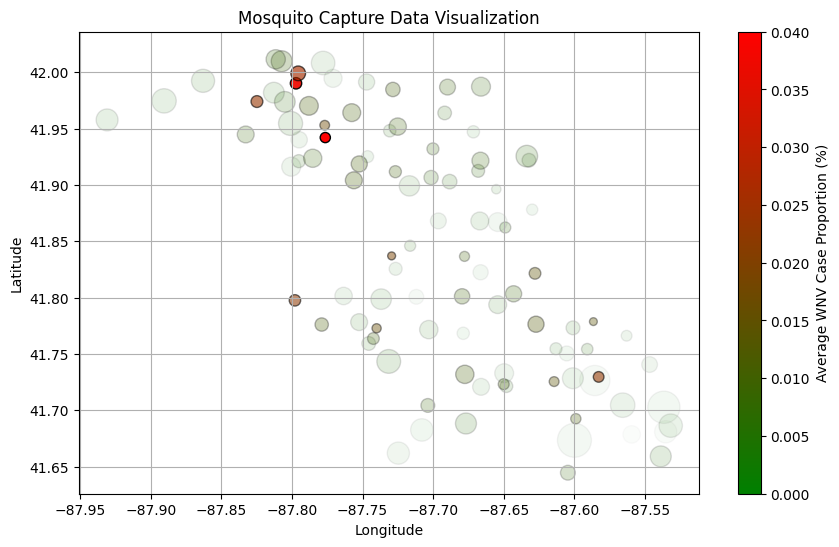

In [321]:
# Create a custom colormap from green to red
colors = ["green", "red"]
cmap = LinearSegmentedColormap.from_list("custom_green_red", colors, N=256)

# Assuming 'grouped' is your DataFrame prepared as before
grouped = train_weather.groupby(['Latitude', 'Longitude']).agg(
    Avg_Mosquitoes=pd.NamedAgg(column='NumMosquitos', aggfunc='mean'),
    Avg_WNV_Percentage=pd.NamedAgg(column='wnv_case_proportion', aggfunc='mean')
).reset_index()

# Normalize data for plotting
max_mosquito_count = grouped['Avg_Mosquitoes'].max()
grouped['Normalized_Mosquitoes'] = grouped['Avg_Mosquitoes'] / max_mosquito_count * 600  # Normalize and scale up for visibility

# Normalize transparency based on Avg_WNV_Percentage
# Scale transparency from 0.3 to 1.0 (you can adjust these limits as needed)
alpha_scale = grouped['Avg_WNV_Percentage'] / grouped['Avg_WNV_Percentage'].max()
alphas = 0.0 + (alpha_scale * 1.0)  # Scale and shift

# Create the plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    grouped['Longitude'], grouped['Latitude'], 
    s=grouped['Normalized_Mosquitoes'],  # Size of the marker
    c=grouped['Avg_WNV_Percentage'],  # Color of the marker
    cmap=cmap,  # Custom color map
    alpha=alphas,  # Transparency of the markers
    edgecolor='black'  # Edge color of the markers
)

# Add a color bar
plt.colorbar(sc, label='Average WNV Case Proportion (%)')

# Set plot labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mosquito Capture Data Visualization')
plt.grid(True)  # Optional: turn on the grid

# Show the plot
plt.show()


In [334]:
# Filter for only numeric columns
numeric_df = train_weather.select_dtypes(include=[np.number])
corr_features = [feat for feat in numeric_df.columns if 'lag1' not in feat and '7day' not in feat]
numeric_df_corr = numeric_df.loc[:, [col for col in numeric_df.columns if 'lag1' not in col and '7day' not in col]]

# Calculate the correlation and p-values
# Pearson (default) - continuous variables and assuemes linear relationship
#   - Tmax, Tavg, Tmin, Heat, Cool, WetBulb, DewPoint, and Depart are all highly correlated. Some could be removed.
# Spearman - continuous variables,less sensitive to outliers than Pearson’s, doesn't assume normal distribution, when the relationship is not linear but monotonically
# Cramer’s V - For purely categorical data, use Cramer’s V to assess association.
correlation_matrix = numeric_df_corr.corr()
p_value_matrix = pd.DataFrame(np.zeros_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if i != j:
            _, p_value = pearsonr(numeric_df_corr.iloc[:, i], numeric_df_corr.iloc[:, j])
            p_value_matrix.iloc[i, j] = p_value
        else:
            p_value_matrix.iloc[i, j] = np.nan  # Set diagonal to NaN for clarity


# Create hover text that includes both correlation and p-value
hovertext = [
    [
        f'X: {correlation_matrix.columns[j]}<br>Y: {correlation_matrix.columns[i]}<br>Correlation: {correlation_matrix.iloc[i, j]:.3f}<br>P-value: {p_value_matrix.iloc[i, j]:.3g}'
        for j in range(len(correlation_matrix.columns))
    ] for i in range(len(correlation_matrix.columns))
]

# Create a heatmap with custom hoverinfo using Plotly Graph Objects
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu_r',
    zmin=-1,
    zmax=1,
    hoverinfo="text",
    text=hovertext
))

fig.update_layout(
    autosize=False,  # Allows you to specify width and height
    width=900,
    height=900,
    title='Correlation Matrix with P-values',
    xaxis_title='Variable 1',
    yaxis_title='Variable 2'
)

fig.show()

# Extract the row for 'WnvPresent'
correlation_matrix = numeric_df.corr()
p_value_matrix = pd.DataFrame(np.zeros_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        if i != j:
            _, p_value = pearsonr(numeric_df.iloc[:, i], numeric_df.iloc[:, j])
            p_value_matrix.iloc[i, j] = p_value
        else:
            p_value_matrix.iloc[i, j] = np.nan  # Set diagonal to NaN for clarity


sorted_indices = correlation_matrix.loc['WnvPresent'].drop('WnvPresent').abs().sort_values(ascending=False).index

wnv_p_values = p_value_matrix.loc['WnvPresent'].drop('WnvPresent')
wnv_p_values = wnv_p_values.loc[sorted_indices]

# wnv_correlations = correlation_matrix.loc['WnvPresent'].drop('WnvPresent').sort_values(ascending=False)

wnv_correlations = correlation_matrix.loc['WnvPresent'].drop('WnvPresent').loc[sorted_indices]

hover_text = [
    f'Variable: {idx}<br>Correlation: {wnv_correlations[idx]:.3f}<br>P-value: {wnv_p_values[idx]:.3g}'
    for idx in sorted_indices
]

# Create a bar plot using Plotly
fig = go.Figure(go.Bar(
    x=wnv_correlations.index,
    y=wnv_correlations.values,
    marker_color='blue',  # Customize color
    hovertext=hover_text,
    hoverinfo='text'
))

# Update layout for better readability
fig.update_layout(
    title='Correlation Coefficients of WnvPresent with Other Variables',
    xaxis_title='Variables',
    yaxis_title='Correlation Coefficient',
    xaxis_tickangle=-45  # This tilts the variable names for better visibility
)

# Show the plot
fig.show()

threshold = 0.1
target_col = 'WnvPresent'
relevant_features = correlation_matrix[target_col][correlation_matrix[target_col].abs() >= threshold]
irrelevant_features = correlation_matrix[target_col][correlation_matrix[target_col].abs() <= 0.01]
print("Best features based on correlation threshold:")
print(relevant_features)
print("Features to remove based on correlation less than 0.01:")
print(irrelevant_features)


Best features based on correlation threshold:
Species                   -0.11
NumMosquitos               0.20
WnvPresent                 1.00
Day_of_Year                0.11
Week_of_Year               0.10
Month                      0.10
wnv_case_proportion_alt    0.15
Sunrise                    0.11
DewPoint_lag1              0.11
WetBulb_lag1               0.10
Name: WnvPresent, dtype: float64
Features to remove based on correlation less than 0.01:
Block                 0.00
AddressAccuracy       0.01
Day_of_Month          0.01
PrecipTotal          -0.00
SeaLevel              0.01
ResultDir             0.00
StnPressure_lag1      0.01
ResultDir_7day_avg   -0.00
AvgSpeed_lag1        -0.01
Name: WnvPresent, dtype: float64


Explained variance ratio: [0.2700776  0.11515767]
Number of PCA components to retain: 14


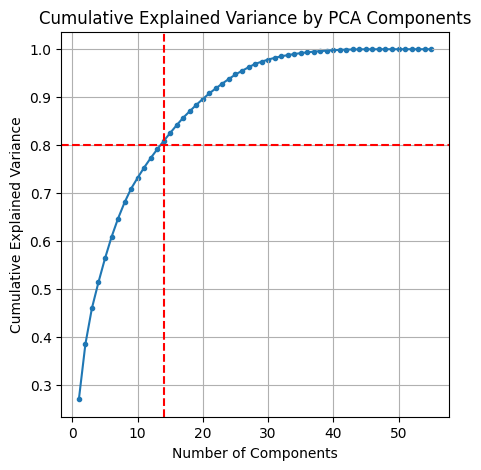

In [341]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure features are correctly defined
# features = ['NumMosquitos', 'Tmax', 'Tmin', 'DewPoint', 'PrecipTotal']
# features = [f'{feat}' for feat in train_weather]
features = numeric_df.columns.tolist()
features
x = train_weather[features].values
x = StandardScaler().fit_transform(x)

# PCA calculation
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Creating a DataFrame with PCA results
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Full PCA for variance explanation
pca_full = PCA()
pca_full.fit(x)

variance_threshold = 0.8
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
num_components = np.where(cumulative_variance >= variance_threshold)[0][0] + 1
print(f"Number of PCA components to retain: {num_components}")

# plt.figure(figsize=(15, 5))

plt.figure(figsize=(5, 5))
plt.plot(np.arange(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_))
plt.scatter(np.arange(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_), marker='.')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.axvline(x=np.where(np.cumsum(pca_full.explained_variance_ratio_) >= 0.8)[0][0] + 1, color='r', linestyle='--')
plt.grid(True)
plt.show()

# PCA loadings
loadings = pca_full.components_.T
loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=features)

# plt.subplot(1,2,2)
# # Heatmap of loadings
# sns.heatmap(loading_matrix.iloc[:, 0:14], annot=False, cmap='coolwarm', center=0)
# plt.title('PCA Loadings')
# plt.xlabel('Principal Components')
# plt.ylabel('Features')

# plt.subplots_adjust(wspace=0.6)  # Adjust the width space between subplots

# plt.show()

# Create hover text that includes information about the loadings
hovertext = [
    [
        f'Feature: {loading_matrix.index[i]}<br>PC: {loading_matrix.columns[j]}<br>Loading: {loading_matrix.iloc[i, j]:.3f}'
        for j in range(len(loading_matrix.iloc[:, 0:14].columns))
    ] for i in range(len(loading_matrix.iloc[:, 0:14].index))
]

# Create a heatmap with custom hoverinfo using Plotly Graph Objects
fig = go.Figure(data=go.Heatmap(
    z=loading_matrix.iloc[:, 0:14].values,
    x=loading_matrix.iloc[:, 0:14].columns,
    y=loading_matrix.iloc[:, 0:14].index,
    colorscale='RdBu_r',
    zmin=-1,
    zmax=1,
    hoverinfo="text",
    text=hovertext
))

fig.update_layout(
    autosize=False,  # Allows you to specify width and height
    width=900,
    height=900,
    title='PCA Loadings Matrix',
    xaxis_title='Principal Components',
    yaxis_title='Features'
)

fig.show()


# # Scree plot for explained variance
# plt.figure(figsize=(10, 6))
# plt.plot(np.arange(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Scree Plot')
# plt.grid(True)
# plt.show()


In [342]:
# Some columns can be dropped immediately as they have little to no use based on correlation and PCA results.

# Drop 'Date' from both train and test datasets
train_weather = train_weather.drop('Date', axis=1)
test_weather = test_weather.drop('Date', axis=1)

# Separate the target variable
X_train = train_weather.drop('WnvPresent', axis=1)
y_train = train_weather['WnvPresent']

In [347]:
# Set params
n_cross_validation = 5

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=25; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=25; total time=   0.0s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=35; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=35; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=35; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=35; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=35; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_estimators=45; total time=   0.1s
[CV] END ..max_depth=1, min_samples_split=2, n_

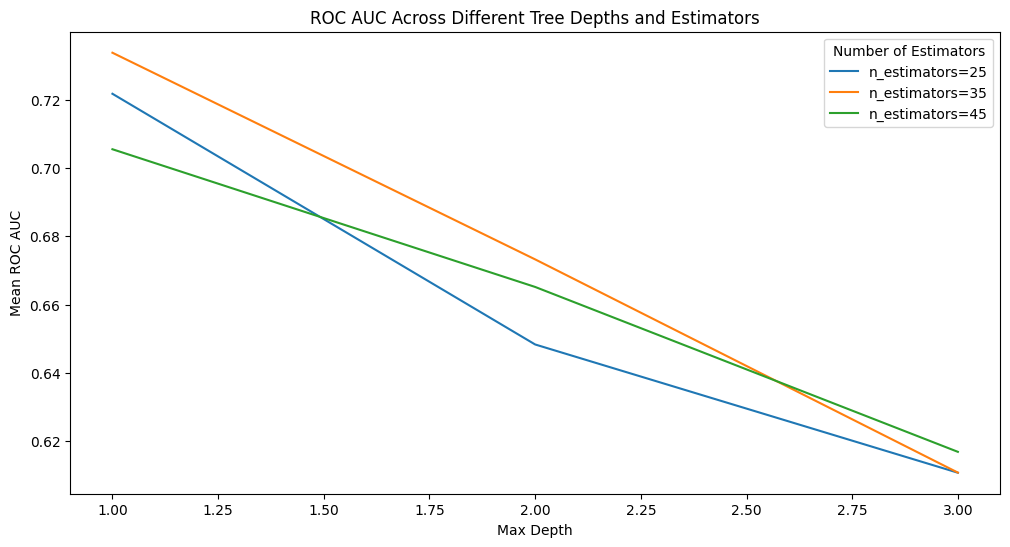

In [350]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 35, 45],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=n_cross_validation, scoring='roc_auc', verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

results = pd.DataFrame(grid_search.cv_results_)

# Plotting each parameter's mean test score across CV folds
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
for param, group in results.groupby('param_n_estimators'):
    group_mean_scores = group.mean_test_score
    ax.plot(group['param_max_depth'], group_mean_scores, label=f'n_estimators={param}')

ax.set_xlabel('Max Depth')
ax.set_ylabel('Mean ROC AUC')
ax.set_title('ROC AUC Across Different Tree Depths and Estimators')
ax.legend(title='Number of Estimators')
plt.show()

# Optionally, retrain or immediately use best_model for predictions
# predictions = best_model.predict(X_test)


In [352]:
# Assuming 'best_model' is the trained RandomForest model with the best parameters found
importances = best_model.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature importances:")
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Feature importances:
NumMosquitos: 0.1714
Sunrise: 0.0857
wnv_case_proportion_alt: 0.0857
Month: 0.0857
Cool: 0.0571
Sunset: 0.0571
Day_of_Year: 0.0571
Week_of_Year: 0.0571
WetBulb_7day_avg: 0.0571
WetBulb_lag1: 0.0571
DewPoint_7day_avg: 0.0571
Species: 0.0286
Tmin_lag1: 0.0286
Tavg: 0.0286
Year: 0.0286
Tmin_7day_avg: 0.0286
DewPoint_lag1: 0.0286
WetBulb: 0.0000
Day_of_Month: 0.0000
Day_of_Week: 0.0000
Location_Cluster: 0.0000
mosquito_proportion: 0.0000
wnv_case_proportion: 0.0000
AddressAccuracy: 0.0000
Tmax: 0.0000
Tmin: 0.0000
Longitude: 0.0000
Depart: 0.0000
Latitude: 0.0000
Trap: 0.0000
Block: 0.0000
DewPoint: 0.0000
AvgSpeed_7day_avg: 0.0000
Heat: 0.0000
Tavg_7day_avg: 0.0000
ResultDir_7day_avg: 0.0000
ResultDir_lag1: 0.0000
ResultSpeed_7day_avg: 0.0000
ResultSpeed_lag1: 0.0000
StnPressure_7day_avg: 0.0000
StnPressure_lag1: 0.0000
PrecipTotal_7day_avg: 0.0000
PrecipTotal_lag1: 0.0000
Tavg_lag1: 0.0000
AvgSpeed_lag1: 0.0000
Tmax_7day_avg: 0.0000
Tmax_lag1: 0.0000
AvgSpeed: 0.0000

In [326]:
# # Define the path to the SQLite database
# database_path = os.path.join('/app/data', 'west_nile_virus.db')

# # Connect to an SQLite database and write the DataFrame
# with sqlite3.connect(database_path) as conn:
#     try:
#         # Export cleaned data to SQLite
#         train.to_sql('train_cleaned', con=conn, index=False, if_exists='replace')
#         test.to_sql('test_cleaned', con=conn, index=False, if_exists='replace')
#         weather.to_sql('weather_cleaned', con=conn, index=False, if_exists='replace')
#         print("Data Inserted Successfully")
        
#         # Confirm data insertion
#         query_result = pd.read_sql_query("SELECT * FROM ads_kpi_dashboard", conn)
#         print("Confirm Data Insertion")
#         print(query_result)
#     except Exception as e:
#         print("Error in database operation:", e)